In [1]:
!pip install einops

import os
import time
from abc import ABC, abstractmethod
from dataclasses import dataclass
from functools import reduce
from operator import mul
from typing import Any, Optional, Union
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import wandb

MAIN = __name__ == "__main__"
IS_CI = os.getenv("IS_CI")


  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.3 MB/s eta 0:00:00


In [2]:
#wandb.login()

In [3]:
DEBUG_TOLERANCES = os.getenv("DEBUG_TOLERANCES")
def allclose(actual: t.Tensor, expected: t.Tensor, rtol=1e-4) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    right = rtol * expected.abs()
    num_wrong = (left > right).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")
        
def assert_shape_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    if actual.shape != expected.shape:
        raise AssertionError(f"expected shape={expected.shape}, got {actual.shape}")

A few samples from the input distribution: 


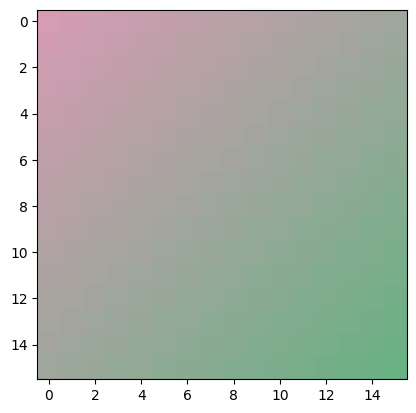

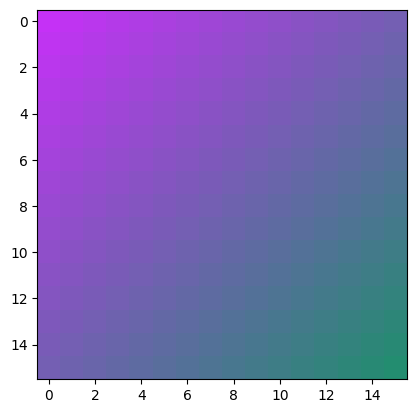

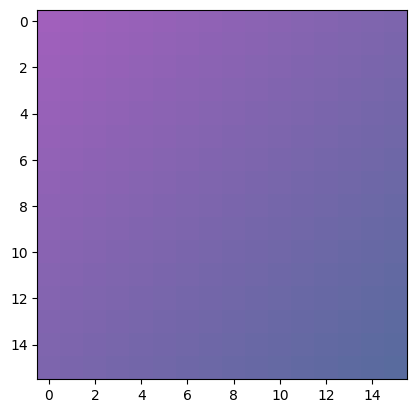

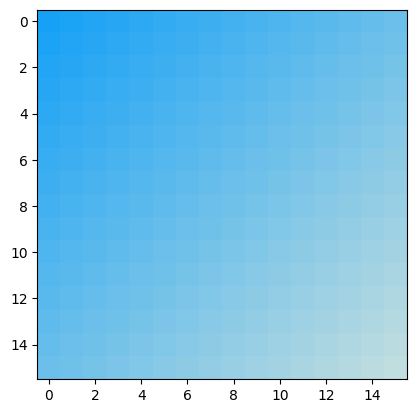

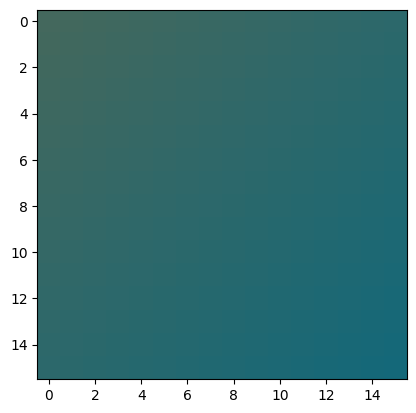

In [4]:
def gradient_images(n_images: int, img_size: tuple[int, int, int]) -> t.Tensor:
    """
    Generate n_images of img_size, each a color gradient
    """
    (C, H, W) = img_size
    corners = t.randint(0, 255, (2, n_images, C))
    xs = t.linspace(0, W / (W + H), W)
    ys = t.linspace(0, H / (W + H), H)
    (x, y) = t.meshgrid(xs, ys, indexing="xy")
    grid = x + y
    grid = grid / grid[-1, -1]
    grid = repeat(grid, "h w -> b c h w", b=n_images, c=C)
    base = repeat(corners[0], "n c -> n c h w", h=H, w=W)
    ranges = repeat(corners[1] - corners[0], "n c -> n c h w", h=H, w=W)
    gradients = base + grid * ranges
    assert gradients.shape == (n_images, C, H, W)
    return gradients / 255

def plot_img(img: t.Tensor, title: Optional[str] = None) -> None:
    if IS_CI:
        return
    img = rearrange(img, "c h w -> h w c")
    plt.imshow(img.numpy())
    if title:
        plt.title(title)
    plt.show()
    
print("A few samples from the input distribution: ")
img_shape = (3, 16, 16)
n_images = 5
imgs = gradient_images(n_images, img_shape)
for i in range(n_images):
    plot_img(imgs[i])

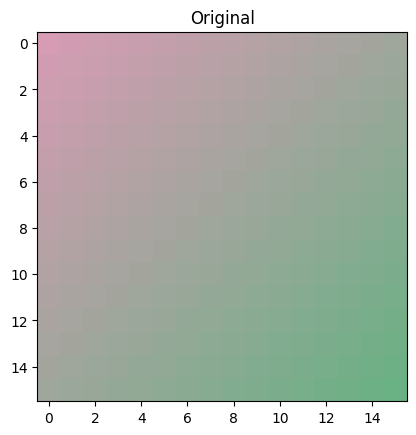

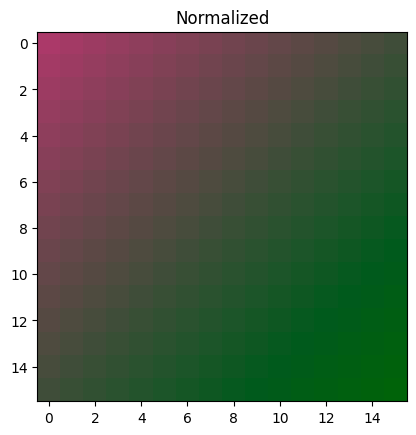

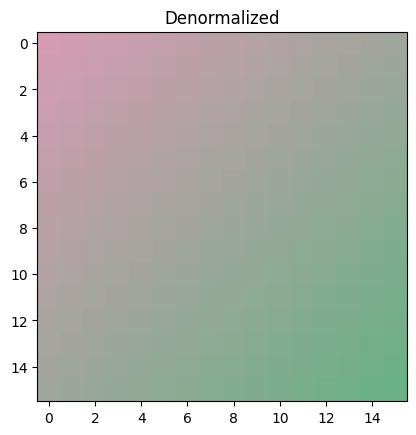

In [5]:
def normalize_img(img: t.Tensor) -> t.Tensor:
    return img * 2 - 1

def denormalize_img(img: t.Tensor) -> t.Tensor:
    return ((img + 1) / 2).clamp(0, 1)

plot_img(imgs[0], "Original")
plot_img(normalize_img(imgs[0]), "Normalized")
plot_img(denormalize_img(normalize_img(imgs[0])), "Denormalized")

In [6]:
def linear_schedule(max_steps: int, min_noise: float = 0.0001, 
                   max_noise: float = 0.02) -> t.Tensor:
    """Return the forward process variances as in the paper.

    max_steps: total number of steps of noise addition
    out: shape (step=max_steps, ) the amount of noise at each step
    """
    return t.linspace(min_noise, max_noise, max_steps)

betas = linear_schedule(max_steps = 200)

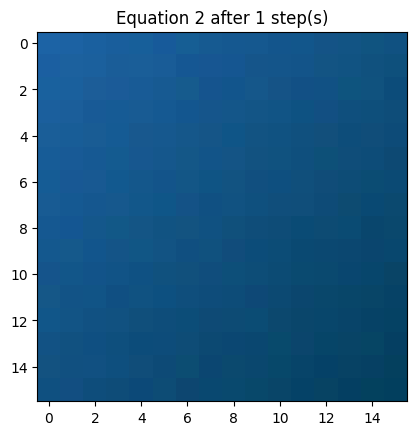

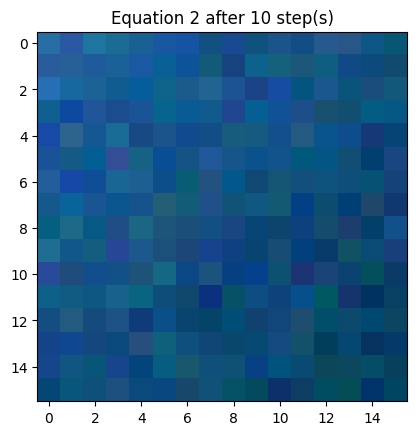

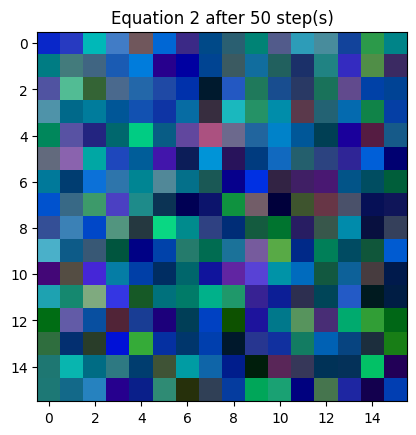

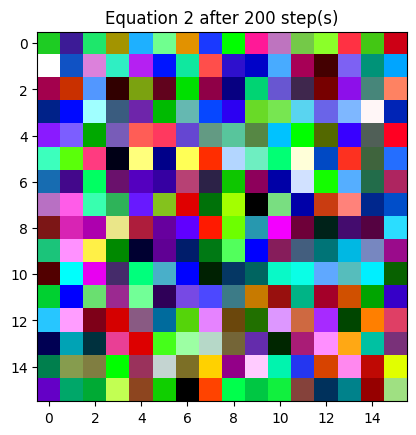

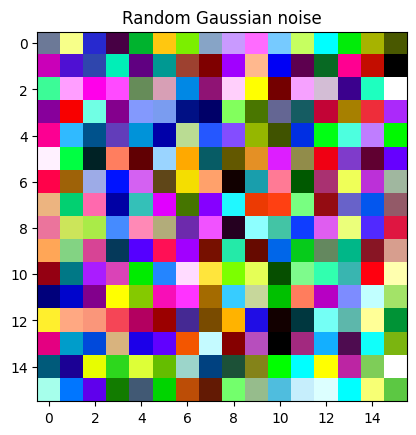

In [7]:
def q_ep2(x: t.Tensor, num_steps: int, betas: t.Tensor) -> t.Tensor:
    """Return the input image with num_steps iterations of noise added according to schedule.
    x: shape (channels, height, width)
    schedule: shape (T, ) with T >= num_steps

    out: shape (channels, height, width)
    """
    xt = x
    for t_step in range(num_steps):
        beta_t = betas[t_step]
        xt = t.normal(mean = ((1 - beta_t) ** 0.5) * xt, std = beta_t ** 0.5)
    return xt

x = normalize_img(gradient_images(1, (3, 16, 16))[0])
for n in [1, 10, 50, 200]:
    xt = q_ep2(x, n, betas)
    plot_img(denormalize_img(xt), f"Equation 2 after {n} step(s)")
plot_img(denormalize_img(t.randn_like(xt)), "Random Gaussian noise")
        



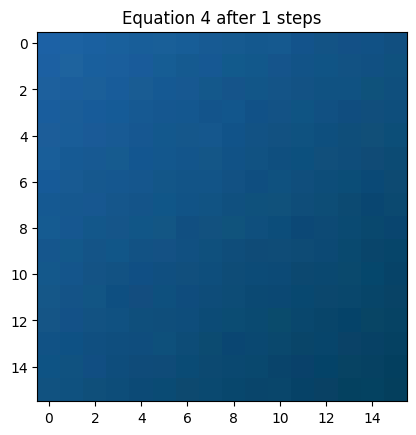

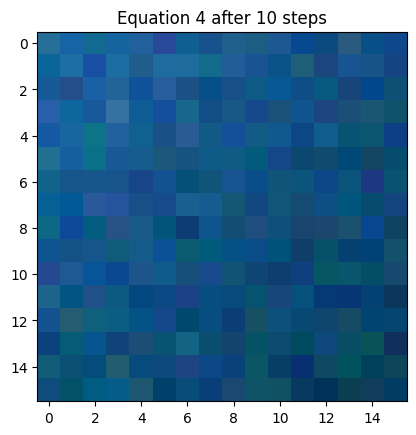

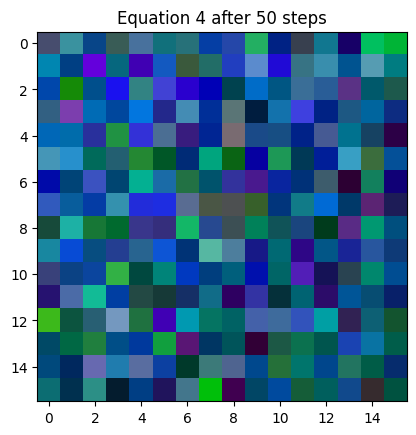

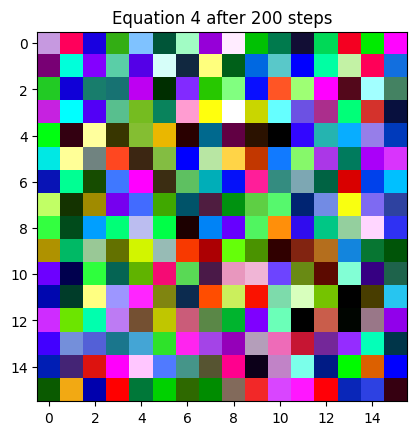

In [8]:
def q_eq4(x: t.Tensor, num_steps: int, beats: t.Tensor) -> t.Tensor:
    """Equivalent to Equation 2 but without a for loop."""
    alphas = 1 - betas
    alpha_bar = t.prod(alphas[:num_steps])
    return t.normal(t.sqrt(alpha_bar) * x, t.sqrt(1 - alpha_bar))

for n in [1, 10, 50, 200]:
    xt = q_eq4(x, n, betas)
    plot_img(denormalize_img(xt), f"Equation 4 after {n} steps")

In [9]:

class NoiseSchedule(nn.Module):
    betas: t.Tensor
    alphas: t.Tensor
    alpha_bars: t.Tensor

    def __init__(self, max_steps: int, device: Union[t.device, str]) -> None:
        super().__init__()
        self.max_steps = max_steps
        self.device = device
        self.register_buffer("betas", linear_schedule(max_steps))
        alphas = 1 - self.betas
        self.register_buffer("alphas", alphas)
        alpha_bars = t.cumprod(alphas, dim=-1)
        self.register_buffer("alpha_bars", alpha_bars)
        self.to(device)

    @t.inference_mode()
    def beta(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the beta(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.betas[num_steps]

    @t.inference_mode()
    def alpha(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the alphas(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.alphas[num_steps]

    @t.inference_mode()
    def alpha_bar(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the alpha_bar(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.alpha_bars[num_steps]

    def __len__(self) -> int:
        return self.max_steps
        

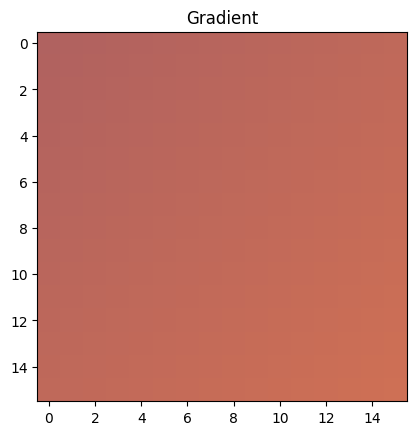

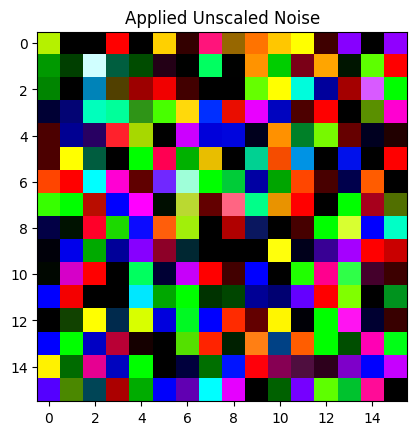

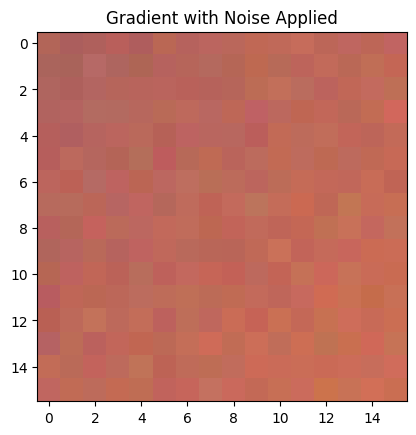

In [10]:
def noise_img(
    img: t.Tensor, noise_schedule: NoiseSchedule, max_steps: Optional[int] = None
) -> tuple[t.Tensor, t.Tensor, t.Tensor]:
    """
    Adds a random number of steps of noise to each image in img.

    img: An image tensor of shape (B, C, H, W)
    noise_schedule: The NoiseSchedule to follow
    max_steps: if provided, only perform the first max_steps of the schedule

    Returns a tuple composed of:
    num_steps: an int tensor of shape (B,) of the number of steps of noise added to each image
    noise: the unscaled, standard Gaussian noise added to each image, a tensor of shape (B, C, H, W)
    noised: the final noised image, a tensor of shape (B, C, H, W)
    """
    B, C, H, W = img.shape
    """SOLUTION"""
    if max_steps is None:
        max_steps = len(noise_schedule)
    assert len(noise_schedule) >= max_steps
    num_steps = t.randint(1, max_steps, size=(B,), device=img.device)
    noise = t.randn_like(img)
    x_scale = noise_schedule.alpha_bar(num_steps).sqrt()
    noise_scale = (1 - noise_schedule.alpha_bar(num_steps)).sqrt()
    noised = (
        repeat(x_scale, "b -> b c h w", c=C, h=H, w=W) * img
        + repeat(noise_scale, "b -> b c h w", c=C, h=H, w=W) * noise
    )
    return num_steps, noise, noised


noise_schedule = NoiseSchedule(max_steps = 200, device = "cpu")
img = gradient_images(1, (3, 16, 16))
(num_steps, noise, noised) = noise_img(normalize_img(img),
                                      noise_schedule, max_steps = 10)
plot_img(img[0], "Gradient")
plot_img(noise[0], "Applied Unscaled Noise")
plot_img(denormalize_img(noised[0]), "Gradient with Noise Applied")

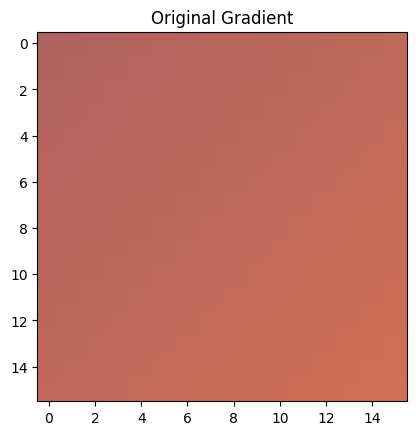

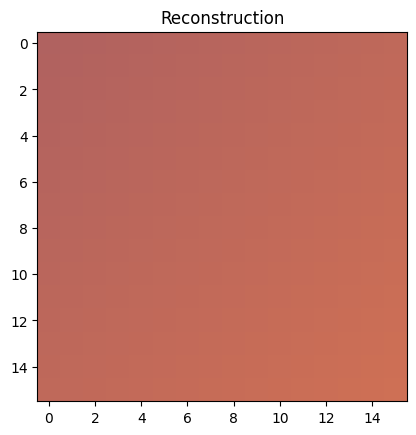

In [11]:
def reconstruct(
    noisy_img: t.Tensor,
    noise: t.Tensor,
    num_steps: t.Tensor,
    noise_schedule: NoiseSchedule,
) -> t.Tensor:
    """
    Subtract the scaled noise from noisy_img to recover the original image. We'll later use this with the model's output to log reconstructions during training. We'll use a different method to sample images once the model is trained.

    Returns img, a tensor with shape (B, C, H, W)
    """
    B, C, H, W = noisy_img.shape
    x_scale = noise_schedule.alpha_bar(num_steps).sqrt()
    noise_scale = (1 - noise_schedule.alpha_bar(num_steps)).sqrt()
    img = noisy_img - repeat(noise_scale, "b -> b c h w", c=C, h=H, w=W) * noise
    img = img / repeat(x_scale, "b -> b c h w", c=C, h=H, w=W)
    assert img.shape == (B, C, H, W)
    return img

reconstructed = reconstruct(noised, noise, num_steps,
                           noise_schedule)
denorm = denormalize_img(reconstructed)
plot_img(img[0], "Original Gradient")
plot_img(denorm[0], "Reconstruction")
allclose(denorm, img)

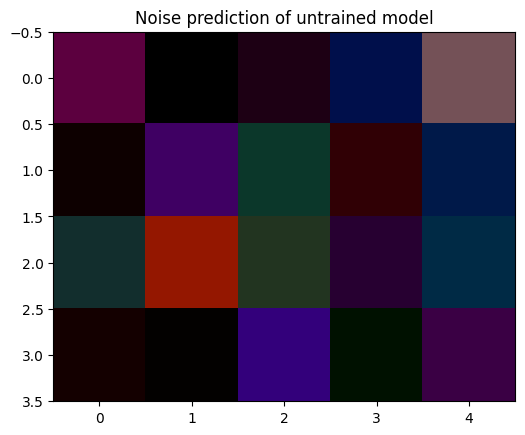

In [12]:
class DiffusionModel(nn.Module, ABC):
    img_shape: tuple[int, ...]
    noise_schedule: Optional[NoiseSchedule]
    
    @abstractmethod
    def forward(self, images: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        ...
        
@dataclass(frozen = True)
class TinyDiffuserConfig:
    img_shape: tuple[int, ...]
    hidden_size: int
    max_steps: int
        
class TinyDiffuser(DiffusionModel):
    def __init__(self, config: TinyDiffuserConfig):
        """
        A toy diffusion model composed of an MLP (Linear, ReLU, Linear)
        """
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.img_shape = config.img_shape
        self.noise_schedule = None
        self.max_steps = config.max_steps
        assert len(config.img_shape) == 3
        self.num_pixels = reduce(mul, img_shape)
        
        self.model = nn.Sequential(
            nn.Linear(self.num_pixels + 1, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.num_pixels),
            Rearrange(
                "b (c h w) -> b c h w",
                c = config.img_shape[0],
                h = config.img_shape[1],
                w = config.img_shape[2],
            ),
        )
        
    def forward(self, images: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        """
        Given a batch of images and noise steps applied, attempt to predict the noise that was applied.
        images: tensor of shape (B, C, H, W)
        num_steps: tensor of shape (B,)

        Returns
        noise_pred: tensor of shape (B, C, H, W)
        """
        B, C, H, W = images.shape
        assert num_steps.shape == (B,)
        num_steps = num_steps / self.max_steps
        model_in = t.cat(
            (
                rearrange(num_steps, "(b 1) -> b 1"),
                rearrange(images, "b c h w -> b (c h w)"),
                
            ),
            dim = -1,
        )
        out = self.model(model_in)
        return out

img_shape = (3, 4, 5)
n_images = 5
imgs = gradient_images(n_images, img_shape)
n_steps = t.zeros(imgs.size(0))
model_config = TinyDiffuserConfig(img_shape, 16, 100)
model = TinyDiffuser(model_config)
out = model(imgs, n_steps)
plot_img(out[0].detach(), "Noise prediction of untrained model")

In [13]:
def log_images(
    img: t.Tensor, noised: t.Tensor, noise: t.Tensor, noise_pred: t.Tensor,
    reconstructed: t.Tensor, num_images: int
) -> list[wandb.Image]:
    """
    Convert tensors to a format suitable for logging to Weights and Biases. Returns an image with the ground truth in the upper row, and model reconstruction on the bottom row. Left is the noised image, middle is noise, and reconstructed image is in the rightmost column.
    """
    actual = t.cat((noised, noise, img), dim = -1)
    pred = t.cat((noised, noise_pred, reconstructed), dim = -1)
    log_img = t.cat((actual, pred), dim = -2)
    images = [wandb.Image(i) for i in log_img[:num_images]]
    return images

def train(
    model: DiffusionModel, config_dict: dict[str, Any],
    trainset: TensorDataset, testset: Optional[TensorDataset] = None
) -> DiffusionModel:
    wandb.init(project = "diffusion_models", config = config_dict,
              job_type = "train",
              group = "part1")
    config = wandb.config
    print(f"Training with config: {config}")
    schedule = NoiseSchedule(config.max_steps, config.device)
    model.noise_schedule = schedule
    
    model.train()
    optimizer = t.optim.Adam(model.parameters(), lr = config.lr)
    train_loader = DataLoader(trainset, batch_size = config.batch_size,
                             shuffle = True)
    if testset is not None:
        test_loader = DataLoader(testset, batch_size = config.batch_size)
    
    start_time = time.time()
    examples_seen = 0
    for epoch in range(config.epochs):
        for i, (x,) in enumerate(tqdm(train_loader, desc = f"Epoch {epoch + 1}")):
            x = x.to(config.device)
            num_steps, noise, noised = noise_img(x, schedule)
            y_hat = model(noised, num_steps)
            loss = F.mse_loss(y_hat, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            info: dict[str, Any] = dict(
                train_loss = loss,
                elapsed = time.time() - start_time,
                y_hat_mean = y_hat.mean(),
                y_hat_var = y_hat.var(),
                noised_mean = noised.mean(),
                noised_var = noised.var(),
            )
            
            if (i + 1) % config.img_log_interval == 0:
                reconstructed = reconstruct(noised, y_hat, num_steps, schedule)
                info["images"] = log_images(
                    img = x,
                    noised = noised,
                    noise = noise,
                    noise_pred = y_hat,
                    reconstructed = reconstructed,
                    num_images = config.n_images_to_log,
                    
                )
            examples_seen += len(x)
            wandb.log(info, step=examples_seen)
            
        if testset is not None:
            losses = []
            for i, (x,) in enumerate(tqdm(test_loader, desc = f"Eval for Epoch {epoch + 1}")):
                x = x.to(config.device)
                num_steps, noise, noised = noise_img(x, schedule)
                with t.inference_mode():
                    y_hat = model(noised, num_steps)
                    loss = F.mse_loss(y_hat, noise)
                losses.append(loss.item())
            eval_info = dict(eval_loss = sum(losses) / len(losses))
            wandb.log(eval_info, step = examples_seen)
        
    wandb.finish()
    return model
            

config: dict[str, Any] = dict(
    lr = 0.001,
    image_shape = (3, 4, 5),
    hidden_size = 128,
    epochs = 20 if not IS_CI else 1,
    max_steps = 100,
    batch_size = 128,
    img_log_interval = 200,
    n_images_to_log=3,
    n_images=50000 if not IS_CI else 10,
    n_eval_images=1000 if not IS_CI else 10,
    device = t.device("cuda") if t.cuda.is_available() else t.device("cpu"),
)

images = normalize_img(gradient_images(config["n_images"], config["image_shape"]))
train_set = TensorDataset(images)
images = normalize_img(gradient_images(config["n_eval_images"], config["image_shape"]))
test_set = TensorDataset(images)
model_config = TinyDiffuserConfig(config["image_shape"], config["hidden_size"],
                                 config["max_steps"])
model = TinyDiffuser(model_config).to(config["device"])
model = train(model, config, train_set, test_set)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training with config: {'lr': 0.001, 'image_shape': [3, 4, 5], 'hidden_size': 128, 'epochs': 20, 'max_steps': 100, 'batch_size': 128, 'img_log_interval': 200, 'n_images_to_log': 3, 'n_images': 50000, 'n_eval_images': 1000, 'device': 'cpu'}


Eval for Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 479.16it/s]


elapsed,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval_loss,█▇▇▆▆▅▆▅▅▅▄▄▄▃▂▂▁▁▁▁
noised_mean,▃▃▅▇▄▄▂▃▃▄▅▅▄▃▆█▄▆▄▄▄▅▅▃▂▅▃▃▁▄▃▅▃▃▄▄▄▆▄▅
noised_var,▄▅▇▆▄▃▁▁▆▅▇▂▄▆▅▃▅█▁▆▂▁▂▆▇▃▆▁▃▄▁▄▆▃▄▄▃▅▂▃
train_loss,█▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁
y_hat_mean,▅▂█▆▄▆▄▃▅▄▁▆▄▄▅▆▅▅▄▃▅▅▅▆▅▄▄▆▄▆▆▃▁▄▁▅▁▆▆▇
y_hat_var,▁▆▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇█▇█▆▇▇▇█▇▇▇▇▇▇▇█▇██▇█▇▇
elapsed,30.79649
eval_loss,0.19432
noised_mean,0.01066
noised_var,0.3777


Generating multiple images


100%|██████████| 100/100 [00:00<00:00, 2904.54it/s]


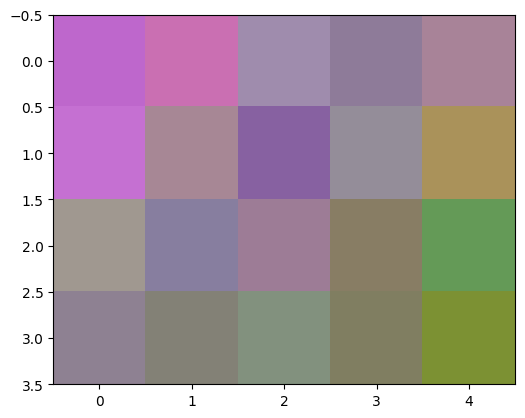

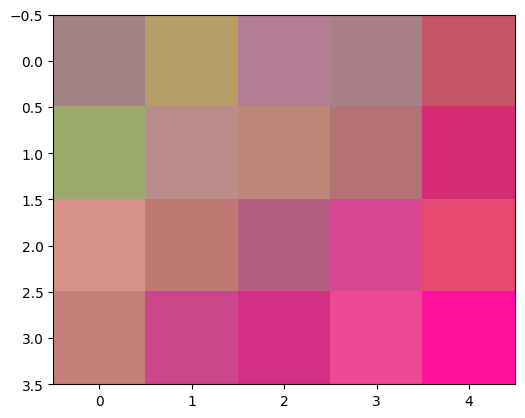

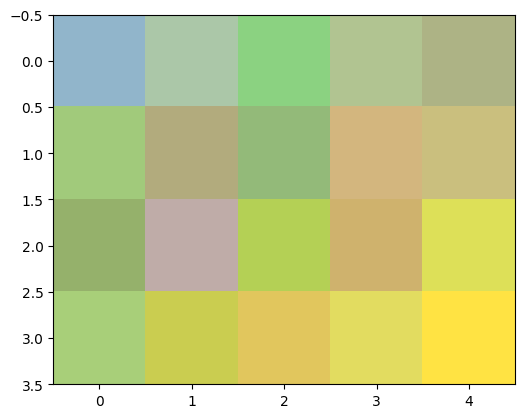

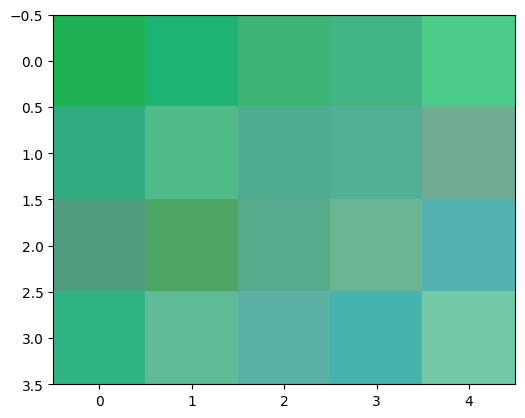

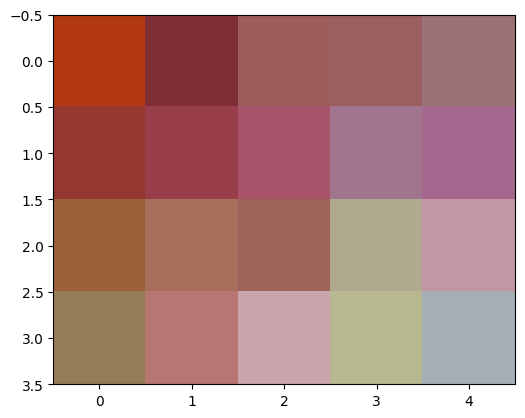

Printing sequential denoising


100%|██████████| 100/100 [00:00<00:00, 2694.34it/s]


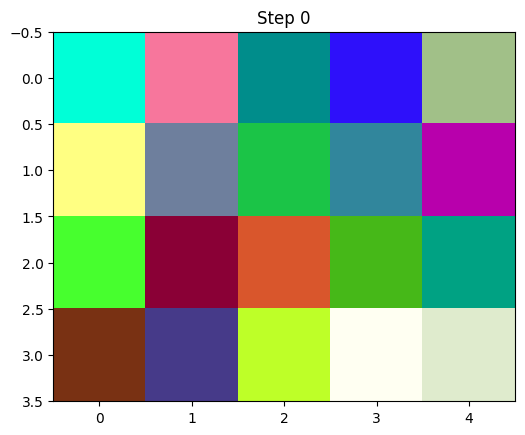

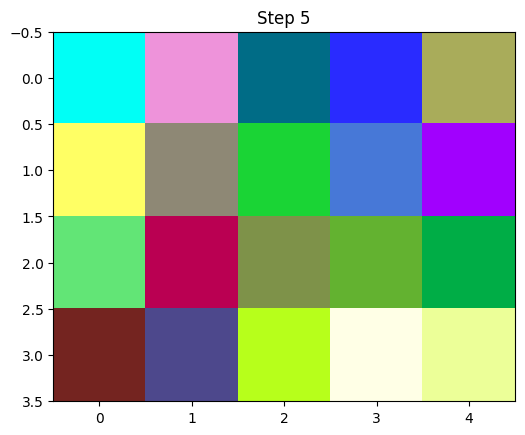

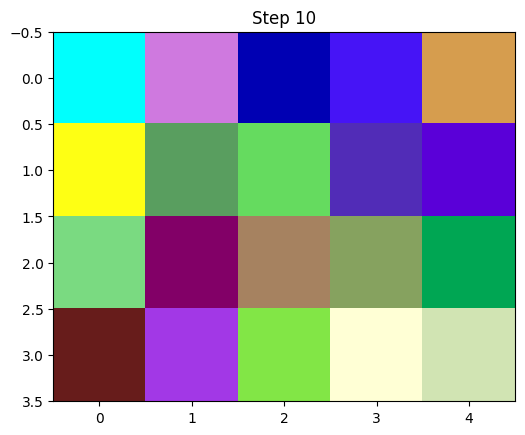

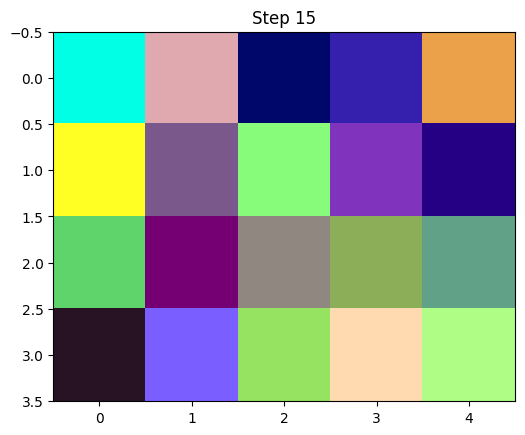

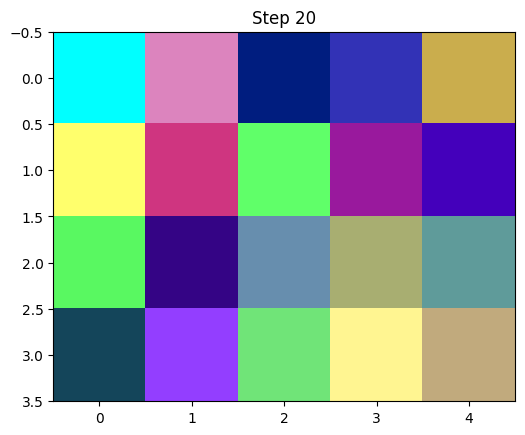

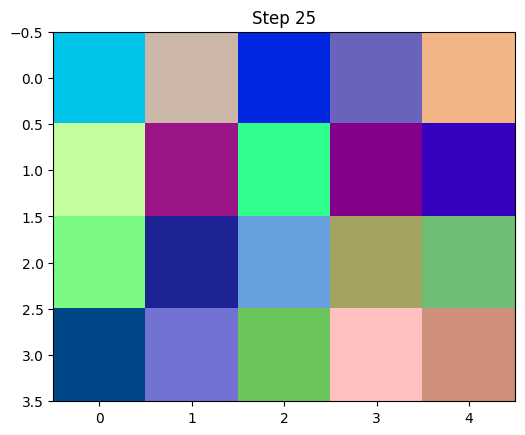

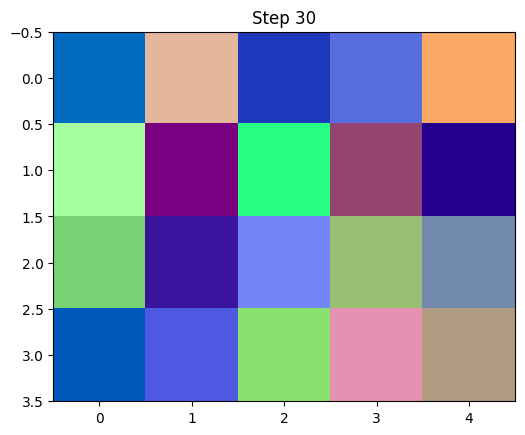

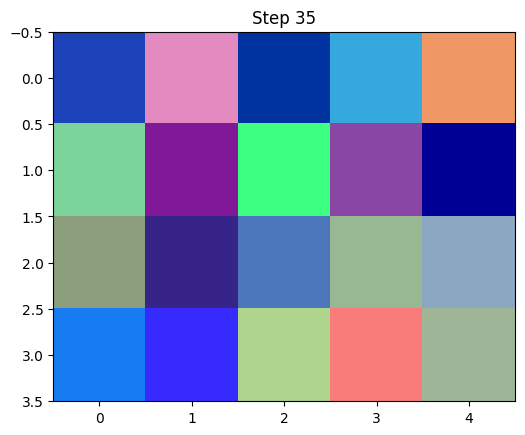

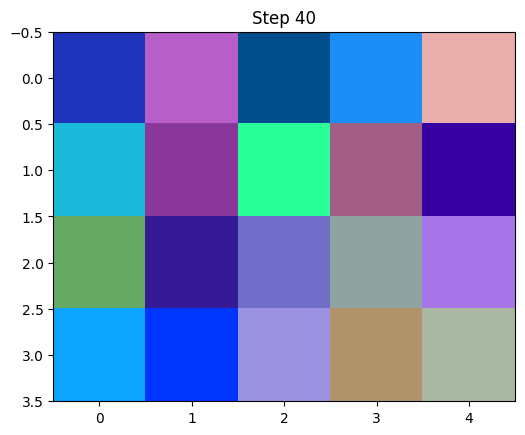

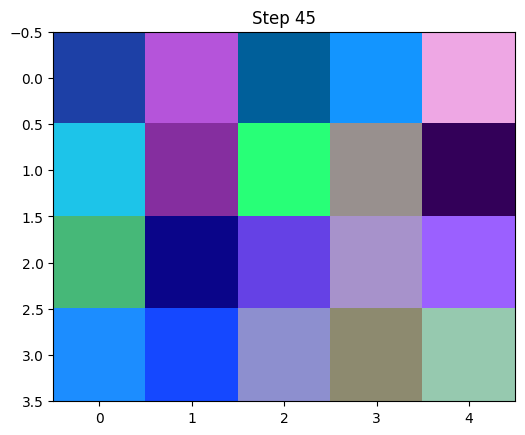

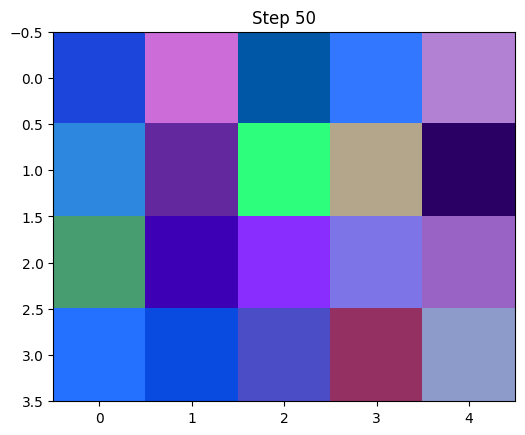

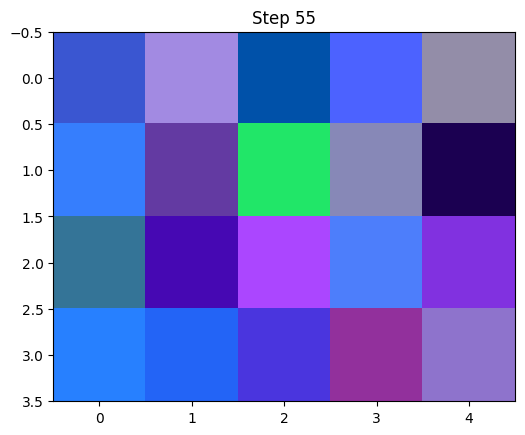

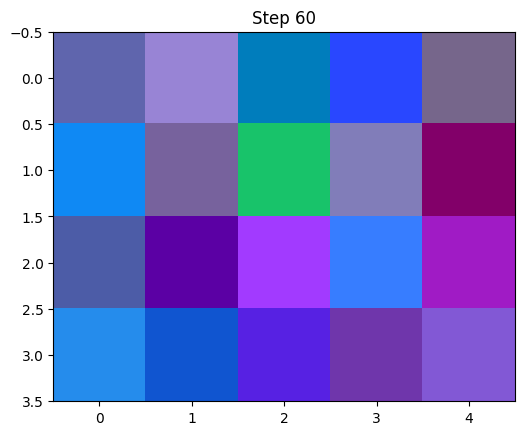

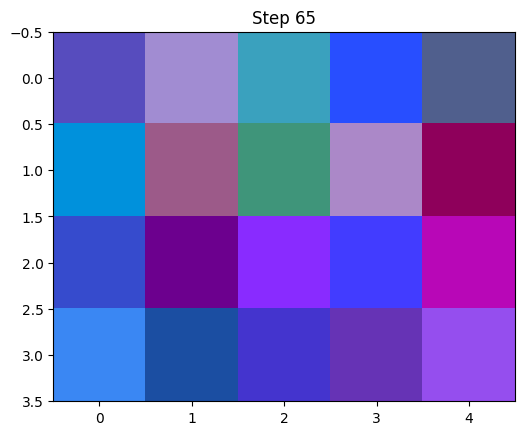

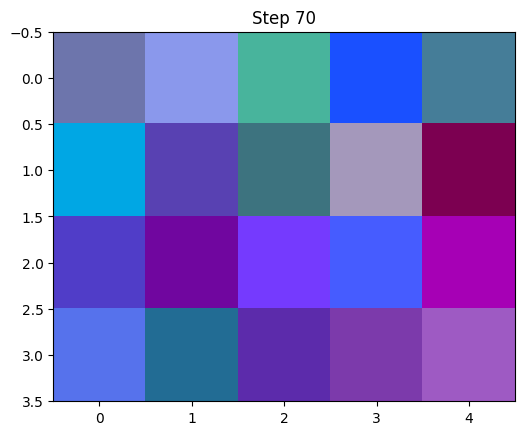

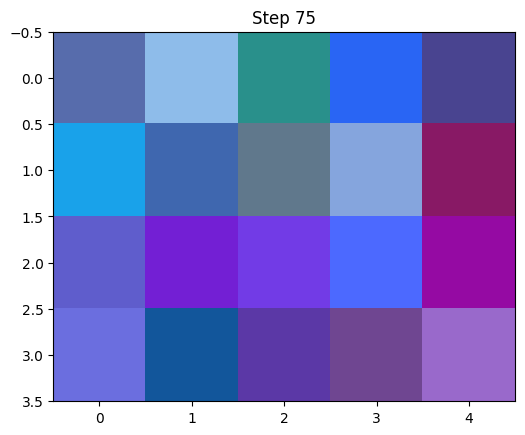

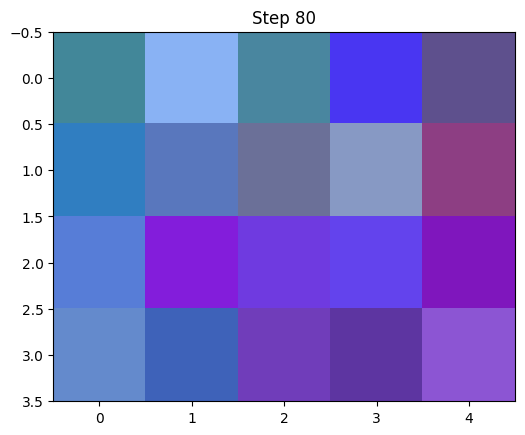

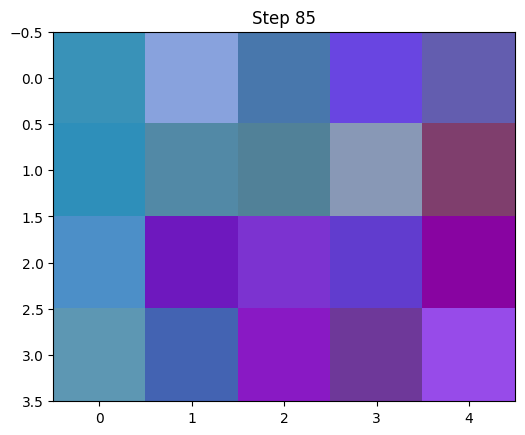

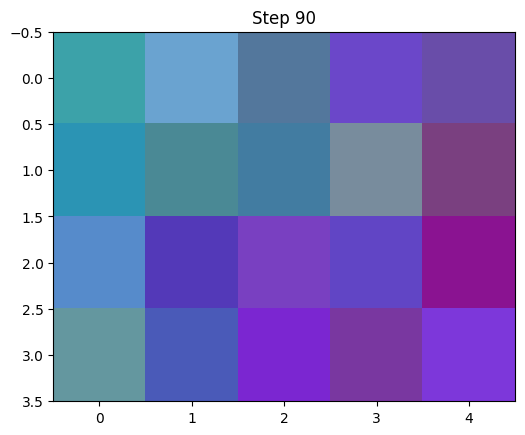

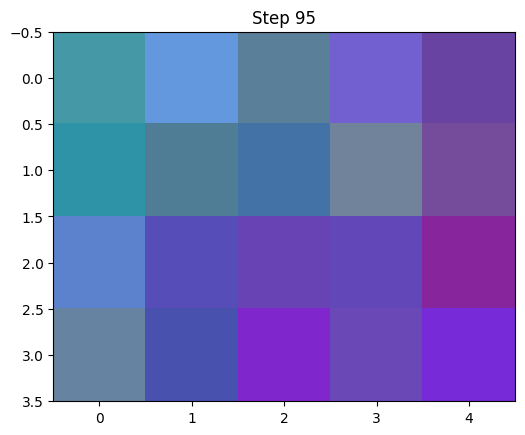

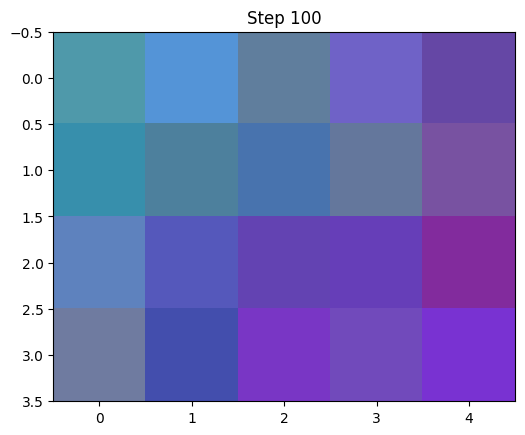

In [21]:
def sample(model: DiffusionModel, n_samples: int, return_all_steps: bool = False) -> Union[t.Tensor, list[t.Tensor]]:
    """
    Sample, following Algorithm 2 in the DDPM paper

    model: The trained noise-predictor
    n_samples: The number of samples to generate
    return_all_steps: if true, return a list of the reconstructed tensors generated at each step, rather than just the final reconstructed image tensor.

    out: shape (B, C, H, W), the denoised images
    """
    schedule = model.noise_schedule
    if return_all_steps:
        all_steps: list[t.Tensor] = []
            
    shape = (n_samples, *model.img_shape)
    B, C, H, W = shape
    Xt = t.randn(shape, device=schedule.device)
    if return_all_steps:
        all_steps.append(Xt.cpu().clone())
    model.eval()
    
    for step in tqdm(reversed(range(0, len(schedule))), total = len(schedule)):
        num_steps = t.full((n_samples,), fill_value=step, device=schedule.device)
        if step > 1:
            sigma = schedule.beta(step).sqrt()
            noise = sigma * t.randn_like(Xt)
        else:
            noise = 0
        
        pred = model(Xt, num_steps)
        pred_scale = schedule.beta(step) / t.sqrt(1 - schedule.alpha_bar(step))
        denoised_scale = 1 / (t.sqrt(schedule.alpha(step)))
        Xt = denoised_scale * (Xt - pred_scale * pred) + noise
        
        if return_all_steps:
            all_steps.append(Xt.cpu().clone())
            
    if return_all_steps:
        return all_steps
    return Xt
            
        
            
        
    

print("Generating multiple images")
assert isinstance(model, DiffusionModel)
with t.inference_mode():
    samples = sample(model, 5)
for s in samples:
    plot_img(denormalize_img(s).cpu())
    
print("Printing sequential denoising")
assert isinstance(model, DiffusionModel)
with t.inference_mode():
    samples = sample(model, 1, return_all_steps = True)

for (i, s) in enumerate(samples):
    if i % (len(samples) // 20) == 0:
        plot_img(denormalize_img(s[0]), f"Step {i}")